# Notes on simulating EEG/MEG/etc data using MNE simulator and data structures

- Requirements:
- Easily adjust duration, num channels
- sampling rate should either be adjustable or on the higher end of what's typically used
- ideally there should be groups (EEG, MEG, misc bio sensors)

starting by looking at this notebook: https://mne.tools/dev/auto_examples/simulation/simulate_raw_data.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import find_events, Epochs, compute_covariance, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (
    simulate_sparse_stc,
    simulate_raw,
    add_noise,
    add_ecg,
    add_eog,
)

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
data_path = sample.data_path(path='/Users/droumis/data/MNE-sample-data') # will save data to ~/mne-data unless `path` arg is specified

100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 952GB/s]
Untarring contents of '/Users/droumis/data/MNE-sample-data/MNE-sample-data-processed.tar.gz' to '/Users/droumis/data/MNE-sample-data'


In [3]:
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)

Opening raw data file /Users/droumis/data/MNE-sample-data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~3.2 MB, data not loaded>

### NTS: Ok, so they are loading a real dataset as a template.. am I going to be limited by the duration or channel count of the template?

Generate dipole time series

### NTS: the number of dipoles doesn't increase duration of the resulting sim_data but it does add more sinusoids to the STC

In [203]:
n_dipoles = 20  # number of dipoles (groups of active neurons) to create
epoch_duration = 10.0  # duration of each epoch/event (max ~270)
n = 0  # harmonic number
rng = np.random.RandomState(0)  # random state (make reproducible)

### NTS: changing the epoch_duration changes the 'times' below which controls the duration, but only up to 4.6 minutes - the duration of the template

In [204]:
def data_fun(times):
    """Generate time-staggered sinusoids at harmonics of 10Hz"""
    global n
    n_samp = len(times)
    window = np.zeros(n_samp)
    start, stop = [
        int(ii * float(n_samp) / (2 * n_dipoles)) for ii in (2 * n, 2 * n + 1)
    ]
    window[start:stop] = 1.0
    n += 1
    data = 25e-9 * np.sin(2.0 * np.pi * 10.0 * n * times)
    data *= window
    return data

In [205]:
print(int(raw.info["sfreq"] * epoch_duration))

6006


In [206]:
duration_min = raw.times.shape[0]/raw.info["sfreq"]/60
duration_min

4.628589104835985

In [207]:
times = raw.times[: int(raw.info["sfreq"] * epoch_duration)]

In [208]:
times.shape

(6006,)

In [209]:
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]
stc = simulate_sparse_stc(
    src, n_dipoles=n_dipoles, times=times, data_fun=data_fun, random_state=rng
)

Reading forward solution from /Users/droumis/data/MNE-sample-data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


### NTS: I think I can just take the default data_fun.. also, because we are not using 'labels' arg which tells it which neural locations (sources) to get vertices for, it just selects randomly I think

In [243]:
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]
stc = simulate_sparse_stc(src, n_dipoles=n_dipoles, times=times, random_state=rng)

Reading forward solution from /Users/droumis/data/MNE-sample-data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


In [244]:
times.shape

(6006,)

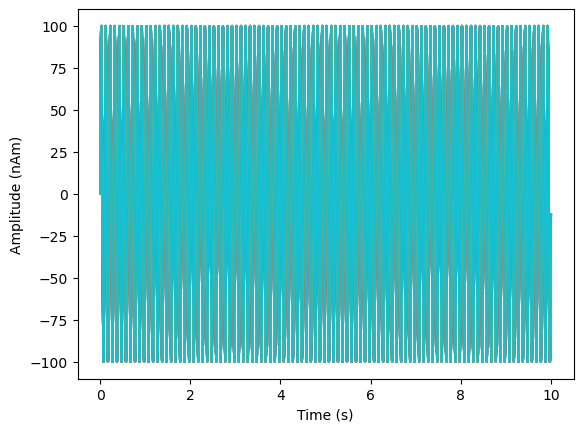

In [245]:
# look at our source data
fig, ax = plt.subplots(1)
ax.plot(times, 1e9 * stc.data.T)
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
mne.viz.utils.plt_show()

### NTS: ok so every row in the stc data is a separate sinusoid/dipole

In [246]:
stc.data.shape # n_dipoles x len_times

(20, 6006)

### NTS: what is the purpose of these sinusoids?
- These are getting tiled to create the raw data. Here is the zscore minimap showing a few repeats of the 4 sinusoids without noise added:
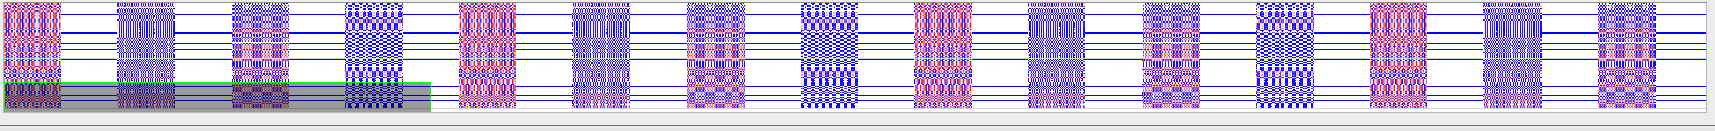
- it looks like theere is some variance for the amount of the sinusoid added to each channel.. I'm not sure what that is based on.. maybe the forward model and position of the channels? because it's consistent within channel/sinusoid
### NTS: is there some vertex location information in the STC data?

In [223]:
print(len(stc.vertices))

2


In [224]:
print(len(stc.vertices[0]))

10


In [230]:
stc.vertices

[array([ 29581,  44569,  46021,  59315,  77555,  89253,  91224, 103449,
        121306, 153933]),
 array([ 25453,  32434,  33958,  41968,  42088,  43793,  77539,  83880,
        112116, 151470])]

### NTS: what are these numbers referring to?

```
In the MNE STC (Source Time Course) data structure, the "stc.vertices" attribute represents the indices of the source vertices in the cortical surface mesh.

The cortical surface mesh is a representation of the brain's cortex, typically derived from structural MRI data. It consists of a set of vertices (points) that define the surface geometry. Each vertex is assigned a unique index that corresponds to its position in the mesh.

In the STC data structure, the "stc.vertices" attribute is an array or list that contains the indices of the vertices associated with the estimated source activity. These indices indicate the specific source locations in the cortical surface mesh where the estimated neural activity is defined.

The "stc.vertices" attribute is typically a two-dimensional array with shape (n_sources, n_vertices_per_source). Each row corresponds to a different source location, and the values in each row represent the indices of the vertices associated with that source.

For example, if "stc.vertices" is [[10, 20, 30], [15, 25, 35]], it means that the estimated activity for the first source is associated with vertices 10, 20, and 30 in the cortical surface mesh, and the estimated activity for the second source is associated with vertices 15, 25, and 35.

The vertex indices in "stc.vertices" are crucial for mapping the estimated source activity back to the cortical surface and visualizing the results in the context of brain anatomy. They provide the spatial information necessary to associate the estimated neural activity with specific regions or locations on the cortical surface.
```

#### NTS: soo... these are apparently indices into some cortical mesh surface.. and each of these two (because list of two arrays) sources (underlying areas of activity) is associated with a number of vertices (cortical surface points)...?

##### NTS: where is this cortical mesh surface into which these index?
```
In MNE, the "fwd.fif" file is a forward solution file that contains the result of the forward model. It provides information about how electrical or magnetic activity generated by neural sources in the brain propagates to the sensors (scalp or MEG/EEG sensors).

The forward solution (often referred to as the forward model) is a mathematical representation of the relationship between the neural sources and the measured sensor data. It takes into account the geometry of the head, the electrical conductivity of the tissues, and the sensor positions and orientations.

The "fwd.fif" file typically contains the following information:

Geometry information: It includes the detailed geometry of the head, such as the cortical surface mesh and the positions of the sensors on the scalp or MEG/EEG sensor array.

Conductivity information: The file specifies the electrical conductivity values for different tissues, such as the brain, skull, and scalp. These values are used to model the propagation of electrical currents through the head.

Source space: The forward solution file defines the spatial grid or locations in the brain where the neural sources are estimated. This can be represented as a set of vertices on the cortical surface or as a discrete grid in a volumetric space.

Forward operator: The core component of the forward solution is the forward operator, which describes the mapping from the estimated source activity to the sensor space. It takes into account the geometry, conductivity, and source locations to compute how the neural activity at each source point would generate electrical or magnetic fields at the sensors.

The vertex indices in the STC (Source Time Course) data structure represent the specific locations on the cortical surface where the estimated neural activity is defined. These indices are used to associate the estimated activity with the vertices in the cortical surface mesh.

The forward solution in the "fwd.fif" file provides the necessary information to map the estimated source activity from the vertices in the source space to the sensor space. By combining the forward solution with the vertex indices in the STC data structure, it is possible to project the estimated neural activity onto the sensor level and compare it with the measured EEG or MEG signals.

In summary, the "fwd.fif" file contains the forward solution, which describes the relationship between the estimated neural sources and the measured sensor data. It is used in conjunction with the vertex indices in the STC data structure to map the estimated source activity onto the sensor level.
```

"To simulate sources, we also need a source space. It can be obtained from the forward solution of the sample subject." from [here](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html#sphx-glr-auto-examples-simulation-simulated-raw-data-using-subject-anatomy-py)

### NTS: ok I created a num_stcs below that was before hardcoded as 10.. this is also increasing the duration

In [247]:
num_stcs = 4
raw_sim = simulate_raw(raw.info, [stc] * num_stcs, forward=fwd, verbose=True)
print(int(raw_sim.times.shape[0] / raw_sim.info["sfreq"])/60, 'min')


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000-10.000 sec
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000-10.000 sec
    Interval 0.000-10.000 sec
    Interval 0.000-10.000 sec
    4 STC iterations provided
[done]
0.65 min


### NTS: The only thing used from the raw template data by this simulator is the raw.info and the raw.times...
- What of the raw.info is being used by simulate_raw? If it's just the channels 

### NTS: what happens if I don't add stc or fwd args?

In [ ]:
# raw_sim = simulate_raw(raw.info)

```
ValueError: src must be a string or instance of SourceSpaces, got None (type <class 'NoneType'>)
```

### NTS: what about without the fwd?

In [249]:
# raw_sim = simulate_raw(raw.info, [stc] * num_stcs)

```
ValueError: src must be a string or instance of SourceSpaces, got None (type <class 'NoneType'>)
```

### add noise to data

In [233]:
# add noise to data
cov = make_ad_hoc_cov(raw_sim.info)
add_noise(raw_sim, cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng) 
add_ecg(raw_sim, random_state=rng) # add ECG noise to raw, apparently inplace
add_eog(raw_sim, random_state=rng) # add blink noise to raw, apparently inplace
# raw_sim.plot()

Adding noise to 366/376 channels (366 channels in cov)
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 0.1 mm
Source location file  : dict()
Assuming input in millimeters
Assuming input in MRI coordinates

Positions (in meters) and orientations
1 sources
ecg simulated and trace not stored
Setting up forward solutions
Computing gain matrix for transform #1/1
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 0.1 mm
Source location file  : dict()
Assuming input in millimeters
Assuming input in MRI coordinates

Positions (in meters) and orientations
2 sources
blink simulated and trace stored on channel:      EOG 061
Setting up forward solutions
Computing gain matrix for transform #1/1


In [240]:
%gui qt5
raw_sim.plot()

Using pyopengl with version 3.1.6


In [183]:
print(int(raw_sim.times.shape[0] / raw.info["sfreq"])/60, 'min')

0.65 min


### NTS: hmm.. epoch_duration of 270 did produce a much longer time series (~45 min) than the original template of 4 min.. can I go any longer?
I guess the viz is already struggling with 45 min of data at 600 Hz so maybe that's fine for now?

## Summarizing what I've learned:

The [mne.simulation.simulate_raw](https://mne.tools/stable/generated/mne.simulation.simulate_raw.html#mne.simulation.simulate_raw) function is what can generate raw data. But this is based on the idea that the user wants to simulate some real underlying neural signal that then gets detected at the sensors, and as such, the function needs:
- info
    - can be from a real raw.info session
    - I haven't figured out yet how to artificially create this info struct yet or what exactly simulate_raw uses from it
- stc (source time course object)
    - I think this is the simulated activity at the neural sources that will be used to generate data at sensor locations
    - [How to create this?](https://mne.tools/stable/simulation.html)
        - SourceSimulator can be used to specify where (label), what (source_time_series), and when (events) event type. You use .add_data to this to create the stc object I guess
        - simulate_stc
        - simulate_sparse_stc
- fwd
    - This is the fwd model that is needed to convert source activity (from stc) to sensory activity
    - Is the fwd file that is read in the examples specific to the the raw.info that gets used to simulate the data? Or can I use the fwd model from the sample data with some other 'info' struct?




## WAIT: AHA
- I can create a raw data structure from scratch and then maybe create a forward model or use the sample one?
- found the following snippet [here](https://mne.tools/stable/auto_tutorials/forward/35_eeg_no_mri.html)

```python
ch_names = \
    'Fz Cz Pz Oz Fp1 Fp2 F3 F4 F7 F8 C3 C4 T7 T8 P3 P4 P7 P8 O1 O2'.split()
data = np.random.RandomState(0).randn(len(ch_names), 1000)
info = mne.create_info(ch_names, 1000., 'eeg')
raw = mne.io.RawArray(data, info)
```

And then looking at [mne.io.RawArray](https://mne.tools/stable/generated/mne.io.RawArray.html#examples-using-mne-io-rawarray).. I find [Tutorial > Creating MNE-Python data structures from scratch](https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html#sphx-glr-auto-tutorials-simulation-10-array-objs-py)

In [4]:
import numpy as np
import mne

# Create some dummy metadata
# n_meg_mag = 2
# n_meg_grad = 4
# n_eeg = 6
# n_eog = 1

# n_channels = 16
sampling_freq = 1000  # in Hertz
# info = mne.create_info(n_channels, sfreq=sampling_freq)
# print(info)

In [5]:
# ch_names = [f'MEG{n:03}' for n in np.arange(1,7)] + [f'EEG{n:03}' for n in np.arange(1,11)]
# ch_types = ['mag'] * 2 + ['grad'] * 4 + ['eeg'] * 10
n_chs = 100
sample_locs = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz']
ch_names = sample_locs + [f'EEG{n:03}' for n in np.arange(1,n_chs+1 - len(sample_locs))]
ch_types = ['eeg'] * n_chs
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020', on_missing='ignore')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fz, Cz, Pz, EEG001, EEG002, EEG003, EEG004, EEG005, ...
 chs: 100 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 100
 projs: []
 sfreq: 1000.0 Hz
>

In [6]:
len(ch_names) == len(ch_types)

True

To create a Raw object from scratch, you can use the mne.io.RawArray class constructor, which takes an Info object and a NumPy array of shape (n_channels, n_samples)

In [11]:
duration = 10 # seconds
freq = 20 # Hz
times = np.linspace(0, duration, sampling_freq*duration, endpoint=False)

In [29]:
sine = np.sin(2 * np.pi * freq * times *20)

# Stack the sine wave across channels
data = np.tile(sine, (n_chs, 1))

In [30]:
data.shape

(100, 10000)

In [31]:
import matplotlib.pyplot as plt

In [32]:
%matplotlib inline

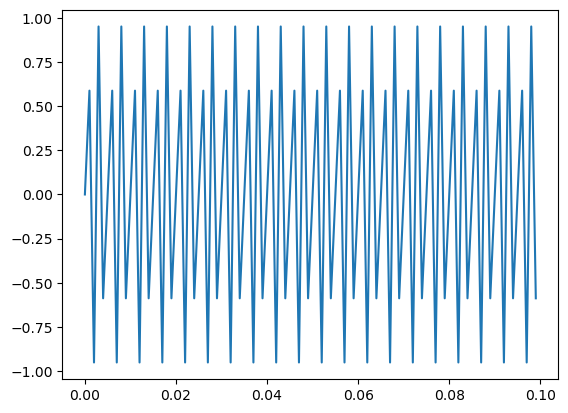

In [33]:
plt.plot(times[:100], data[0,:100])

In [34]:
sim_raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=100, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.


In [35]:
%gui qt5
sim_raw.plot()

Using pyopengl with version 3.1.6


Channels marked as bad:
none


for some  reason the data is not appearing in the qt browser, but whatever

In [19]:
sim_raw

<RawArray | 100 x 10000 (10.0 s), ~7.7 MB, data loaded>

In [36]:
# add noise to data
cov = make_ad_hoc_cov(sim_raw.info)
add_noise(sim_raw, cov)#, iir_filter=[0.2, -0.2, 0.04]) 
# add_ecg(sim_raw) # add ECG noise to raw, apparently inplace. this needs channel location for all chans
# add_eog(sim_raw) # add blink noise to raw, apparently inplace. this needs chaannel location for all chans

Adding noise to 100/100 channels (100 channels in cov)


/var/folders/pp/zp63v9q50m79py9t866mvg3h0000gp/T/ipykernel_97401/1097826750.py:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  add_noise(sim_raw, cov)#, iir_filter=[0.2, -0.2, 0.04])


<RawArray | 100 x 10000 (10.0 s), ~7.7 MB, data loaded>

In [37]:
import hvplot.pandas

In [38]:
df = sim_raw.to_data_frame().set_index('time')
df.head()


,Fp1,Fp2,Fz,Cz,Pz,EEG001,EEG002,EEG003,EEG004,EEG005,...,EEG086,EEG087,EEG088,EEG089,EEG090,EEG091,EEG092,EEG093,EEG094,EEG095
time,,,,,,,,,,,,,,,,,,,,,
0.000,0.311454,-0.161612,0.356883,0.185689,-0.095856,0.003362,0.112238,-0.051415,0.257374,0.143242,...,-0.258708,0.176069,-0.383607,0.290205,-0.214871,-0.394915,0.183665,0.381865,-0.093269,0.184263
0.001,587785.808934,587785.352004,587784.903278,587785.298505,587785.204611,587785.154574,587784.749908,587785.164239,587785.384124,587785.133900,...,587785.367188,587785.091629,587785.215031,587785.253584,587785.301646,587785.414303,587785.240595,587785.075616,587785.333568,587785.100368
0.002,-951056.464970,-951056.209099,-951056.938303,-951056.624567,-951056.419018,-951056.660454,-951056.434993,-951056.520992,-951056.699837,-951057.047996,...,-951056.399951,-951056.529067,-951056.408204,-951056.376685,-951056.845495,-951056.600235,-951056.734129,-951056.642808,-951056.225859,-951056.571887
0.003,951056.647416,951056.762089,951056.426183,951056.618081,951056.835362,951056.720423,951056.445782,951056.446911,951056.698437,951056.726409,...,951056.635855,951056.792263,951056.566108,951056.742621,951056.547844,951056.724460,951056.029615,951056.708513,951056.282557,951056.155992
0.004,-587785.549714,-587784.670587,-587785.137759,-587785.198187,-587785.531311,-587785.200581,-587785.036713,-587785.543841,-587784.953894,-587785.141272,...,-587785.159686,-587785.493145,-587785.007394,-587785.065761,-587785.451564,-587785.124286,-587785.433260,-587784.947170,-587784.798252,-587785.576700


In [39]:
df['Fp1'].hvplot()

:Curve   [time]   (Fp1)

In [52]:
duration = 10
nchs = 200
sampling_freq = 1000  # in Hertz

times = np.linspace(0, duration, sampling_freq*duration, endpoint=False)
sine = np.sin(20 * np.pi * times)
data = np.tile(sine, (nchs, 1))

info = mne.create_info(nchs,
                       ch_types=['misc'] * nchs,
                       sfreq=sampling_freq)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=200, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Using pyopengl with version 3.1.6


Channels marked as bad:
none
